#### Total Size of the Data

In [31]:
import kagglehub
import pandas as pd
import os
import numpy as np
import ast

path = kagglehub.dataset_download("rajathmc/cornell-moviedialog-corpus")
print("Path to dataset files:", path)

# Calculate total size of data
total_size = 0
for filename in os.listdir(path):
    if filename.endswith('.txt'):
        file_size = os.path.getsize(os.path.join(path, filename))
        total_size += file_size
print(f"Total size of data: {total_size / (1024 * 1024):.2f} MB")


Path to dataset files: C:\Users\jbhan\.cache\kagglehub\datasets\rajathmc\cornell-moviedialog-corpus\versions\1
Total size of data: 40.28 MB


In [2]:
from convokit import Corpus, download
corpus = Corpus(filename=download("movie-corpus"))

#### Number of Rows and Columns:

In [32]:
# Load the datasets
movie_lines = pd.read_csv(f"{path}/movie_lines.txt", sep=r' \+\+\+\$\+\+\+ ', header=None,
                          on_bad_lines='skip', encoding='ISO-8859-1', engine='python')
movie_lines.columns = ['LineID', 'CharacterID', 'MovieID', 'CharacterName', 'Text']

movie_conversations = pd.read_csv(f"{path}/movie_conversations.txt", sep=r' \+\+\+\$\+\+\+ ', header=None,
                                  on_bad_lines='skip', encoding='ISO-8859-1', engine='python')
movie_conversations.columns = ['CharacterID1', 'CharacterID2', 'MovieID', 'Conversation']

# Strip whitespace from CharacterIDs in both datasets
movie_lines['CharacterID'] = movie_lines['CharacterID'].str.strip()
movie_conversations['CharacterID1'] = movie_conversations['CharacterID1'].str.strip()
movie_conversations['CharacterID2'] = movie_conversations['CharacterID2'].str.strip()

# Convert to string if necessary
movie_lines['CharacterID'] = movie_lines['CharacterID'].astype(str)
movie_conversations['CharacterID1'] = movie_conversations['CharacterID1'].astype(str)
movie_conversations['CharacterID2'] = movie_conversations['CharacterID2'].astype(str)

print("Number of rows in Movie Lines:", movie_lines.shape[0])
print("Number of columns in Movie Lines:", movie_lines.shape[1])

print("Number of rows in Movie Conversations:", movie_conversations.shape[0])
print("Number of columns in  Movie Conversations:", movie_conversations.shape[1])

# Number of speakers
print("Number of speakers:", len(corpus.speakers))


Number of rows in Movie Lines: 304713
Number of columns in Movie Lines: 5
Number of rows in Movie Conversations: 83097
Number of columns in  Movie Conversations: 4
Number of speakers: 9035


In [4]:
# Load the datasets
movie_lines = pd.read_csv(f"{path}/movie_lines.txt", sep=r' \+\+\+\$\+\+\+ ', header=None,
                          on_bad_lines='skip', encoding='ISO-8859-1', engine='python')
movie_lines.columns = ['LineID', 'CharacterID', 'MovieID', 'CharacterName', 'Text']

movie_conversations = pd.read_csv(f"{path}/movie_conversations.txt", sep=r' \+\+\+\$\+\+\+ ', header=None,
                                  on_bad_lines='skip', encoding='ISO-8859-1', engine='python')
movie_conversations.columns = ['CharacterID1', 'CharacterID2', 'MovieID', 'Conversation']

movie_titles = pd.read_csv(f"{path}/movie_titles_metadata.txt", sep=r' \+\+\+\$\+\+\+ ', 
                          header=None, encoding='ISO-8859-1', engine='python',
                          names=['MovieID', 'Title', 'Year', 'Rating', 'Votes', 'Genres'])

# Strip whitespace from CharacterIDs
movie_lines['CharacterID'] = movie_lines['CharacterID'].str.strip()
movie_conversations['CharacterID1'] = movie_conversations['CharacterID1'].str.strip()
movie_conversations['CharacterID2'] = movie_conversations['CharacterID2'].str.strip()

# Convert to string if necessary
movie_lines['CharacterID'] = movie_lines['CharacterID'].astype(str)
movie_conversations['CharacterID1'] = movie_conversations['CharacterID1'].astype(str)
movie_conversations['CharacterID2'] = movie_conversations['CharacterID2'].astype(str)

# 2. Now create the directed graph
# Create a mapping from LineID to CharacterID
line_to_character = dict(zip(movie_lines['LineID'], movie_lines['CharacterID']))


In [5]:
# Get Fight Club's MovieID
fight_club_id = movie_titles[movie_titles['Title'].str.contains('Fight Club', case=False, na=False)].iloc[0]['MovieID']

# Get all lines from Fight Club
fight_club_lines = movie_lines[movie_lines['MovieID'] == fight_club_id]

# Find Jack's lines (looking for character names that contain 'Jack' or 'Narrator')
jack_lines = fight_club_lines[
    fight_club_lines['CharacterName'].str.contains('Jack|Narrator', case=False, na=False)
]

# Print statistics about Jack's dialogue
# print(f"Number of lines spoken by Jack: {len(jack_lines)}")

# Get average line length
avg_line_length = jack_lines['Text'].str.len().mean()
# print(f"Average length of Jack's lines: {avg_line_length:.1f} characters")

# Get scene partners (characters Jack talks to most)
jack_convos = movie_conversations[
    (movie_conversations['MovieID'] == fight_club_id) & 
    (movie_conversations['CharacterID1'].isin(jack_lines['CharacterID']) |
     movie_conversations['CharacterID2'].isin(jack_lines['CharacterID']))
]

# Print number of conversations Jack appears in
# print(f"\nNumber of conversations involving Jack: {len(jack_convos)}")

# Analyze when in the movie Jack speaks most
jack_lines['Line_Number'] = range(len(jack_lines))
# print("\nDistribution of Jack's lines throughout the movie:")
# print(jack_lines['Line_Number'].describe())

# for line in jack_lines['Text']:
#     print(line)


C:\Users\jbhan\AppData\Local\Temp\ipykernel_8644\2029846588.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jack_lines['Line_Number'] = range(len(jack_lines))


In [35]:
import time
import sys

def typewriter_print(text, delay=0.05):
    for char in text:
        sys.stdout.write(char)
        sys.stdout.flush()
        time.sleep(delay)
    print()  # New line after text is complete

# Find the line index containing "You broke your promise"
target_line = fight_club_lines[
    fight_club_lines['Text'].str.contains("You broke your promise", case=False, na=False)
].index[0]

# Get just the line with "You broke your promise" and the response
context = fight_club_lines.loc[target_line:target_line+1]

# Print just these two lines
for _, line in context.iterrows():
    typewriter_print(f"Character: {line['CharacterName']}", delay=0.0)
    typewriter_print(f"{line['Text']}", delay=0.05)
    typewriter_print("-" * 50, delay=0.0)
    time.sleep(0.1)

Character: TYLER
You broke your promise.  You talked to her about me.
--------------------------------------------------
Character: JACK
Why do people think I'm you?
--------------------------------------------------


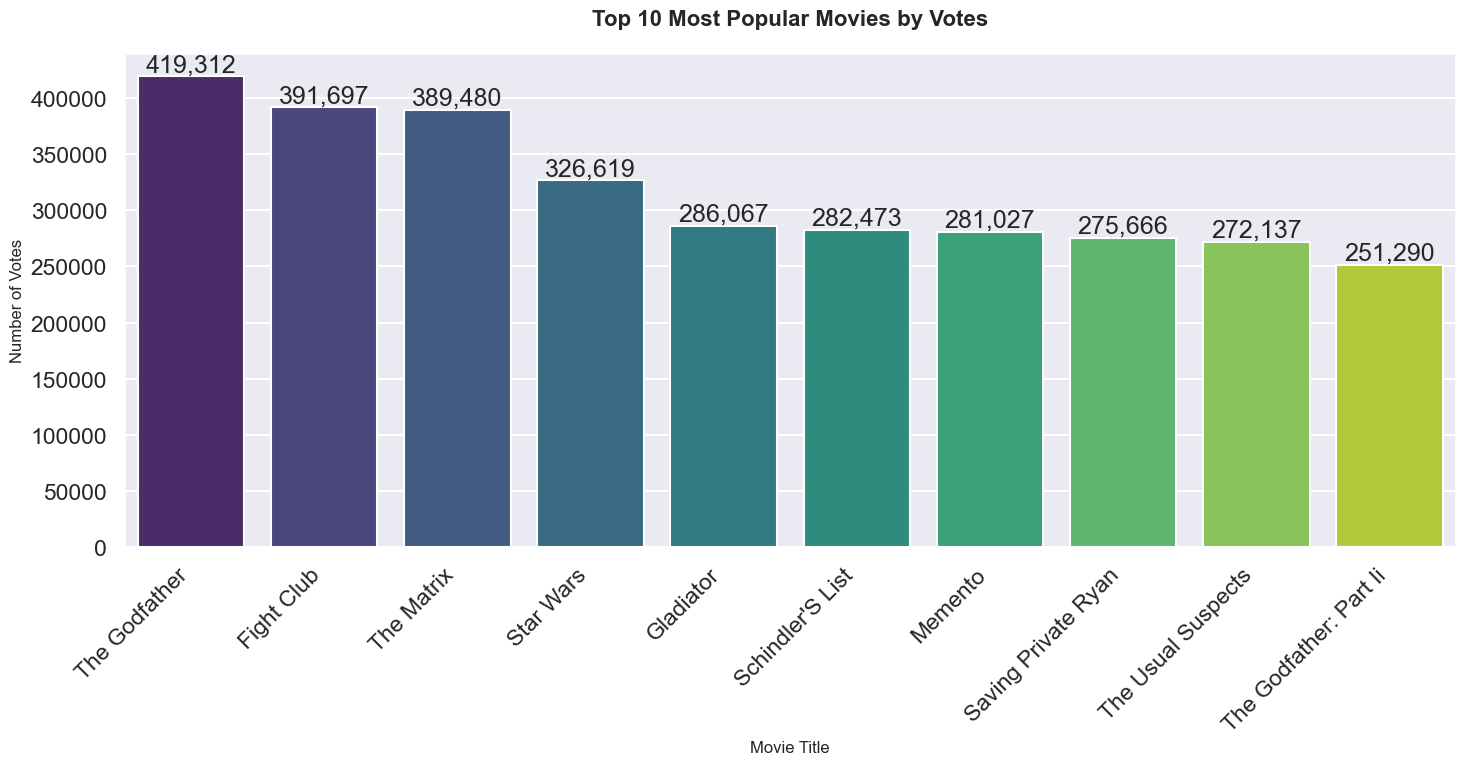

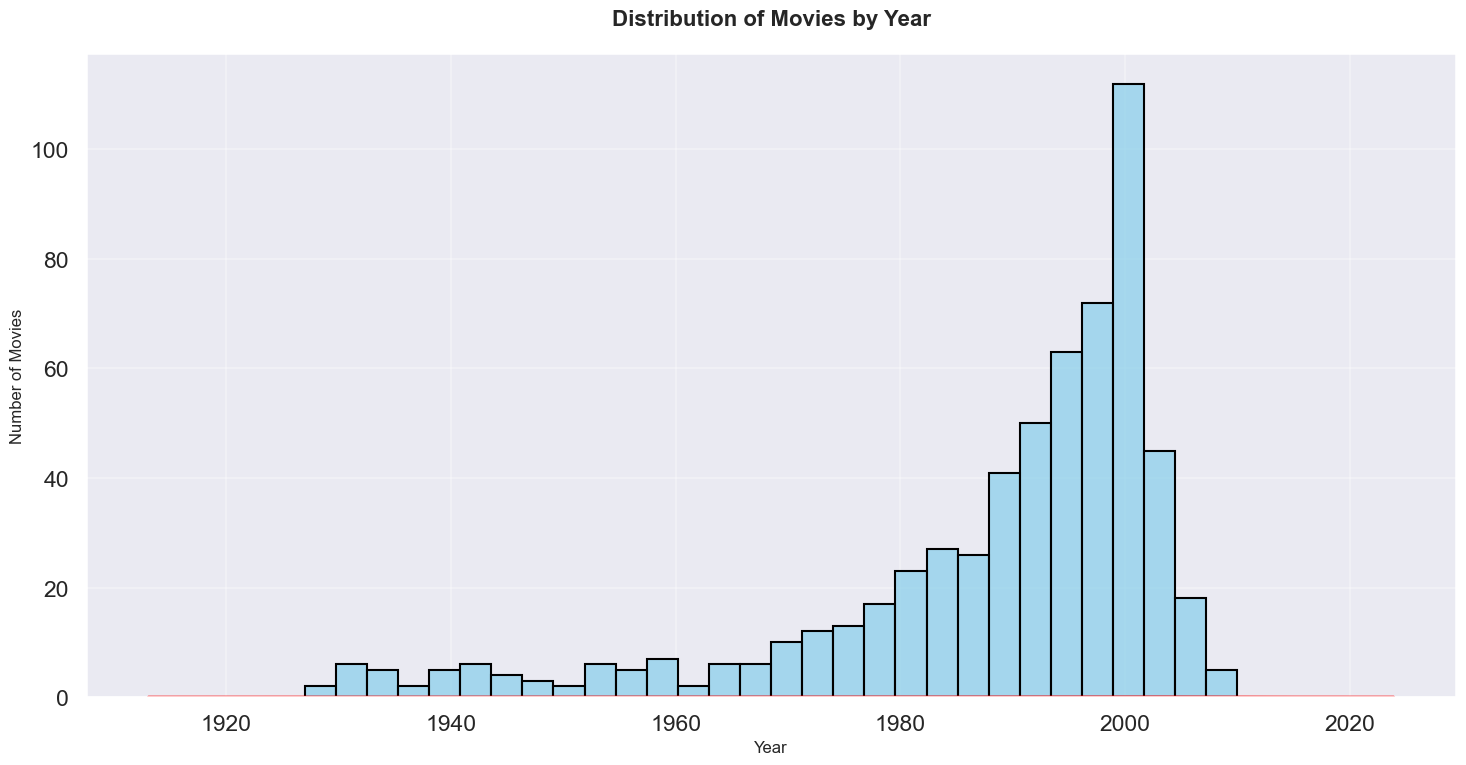

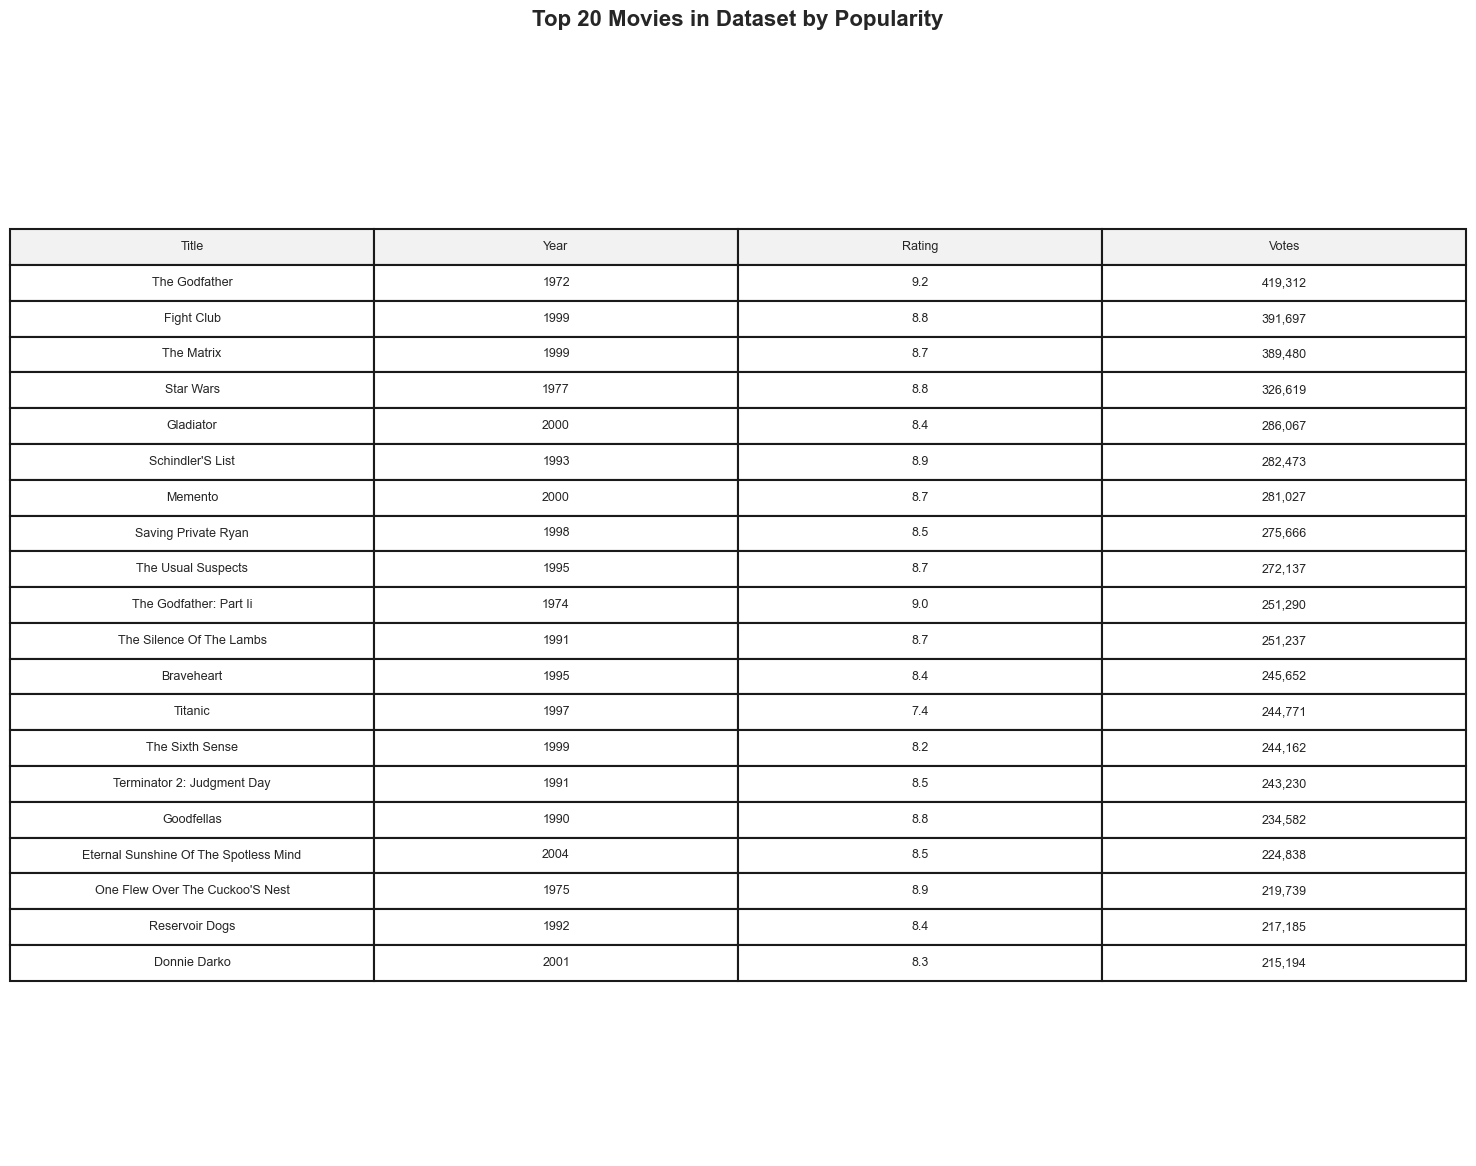

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set the style for all plots - using a valid style name
plt.style.use('default')  # Changed from 'seaborn' to 'default'
sns.set_theme()  # This will apply seaborn's default styling
sns.set_palette("husl")
sns.set_context("talk")

# Sort movies by number of votes and rating
top_movies = movie_titles.sort_values(['Votes', 'Rating'], ascending=[False, False])
top_movies['Votes'] = pd.to_numeric(top_movies['Votes'], errors='coerce')
top_movies['Rating'] = pd.to_numeric(top_movies['Rating'], errors='coerce')
# Capitalize movie titles
top_movies['Title'] = top_movies['Title'].str.title()
top_20_movies = top_movies.head(20)

# Create figure for votes plot
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(
    data=top_20_movies.head(10),
    x='Title',
    y='Votes',
    palette='viridis'
)

# Customize the plot
plt.title('Top 10 Most Popular Movies by Votes', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Movie Title', fontsize=12)
plt.ylabel('Number of Votes', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(top_20_movies['Votes'].head(10)):
    bar_plot.text(i, v, f'{int(v):,}', ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

# Create figure for year distribution
plt.figure(figsize=(15, 8))
years = pd.to_numeric(movie_titles['Year'], errors='coerce').dropna()

sns.histplot(
    data=years,
    bins=30,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)

# Add a kernel density estimate
sns.kdeplot(data=years, color='red', linewidth=2)

plt.title('Distribution of Movies by Year', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Create a table-like visualization for top 20 movies
plt.figure(figsize=(15, 12))
table_data = top_20_movies[['Title', 'Year', 'Rating', 'Votes']].copy()
table_data['Votes'] = table_data['Votes'].apply(lambda x: f'{int(x):,}')
table_data['Rating'] = table_data['Rating'].round(1)

# Create a table plot
table = plt.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f2f2f2']*4,
    cellColours=[['#ffffff']*4]*len(table_data)
)

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.8)

# Hide axes
plt.axis('off')

plt.title('Top 20 Movies in Dataset by Popularity', pad=20, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### Network Analysis (Undirected Graph)

In [8]:
import networkx as nx

# Construct Character Interaction Network
G = nx.Graph()

for _, row in movie_conversations.iterrows():
    char1, char2 = row['CharacterID1'], row['CharacterID2']
    if G.has_edge(char1, char2):
        G[char1][char2]['weight'] += 1
    else:
        G.add_edge(char1, char2, weight=1)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

# Degree distribution
degrees = [val for (node, val) in G.degree()]
print("Average degree:", sum(degrees) / len(degrees))


Number of nodes: 9035
Number of edges: 10292
Average degree: 2.27825124515772


C:\Users\jbhan\AppData\Local\Temp\ipykernel_8644\3457280579.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


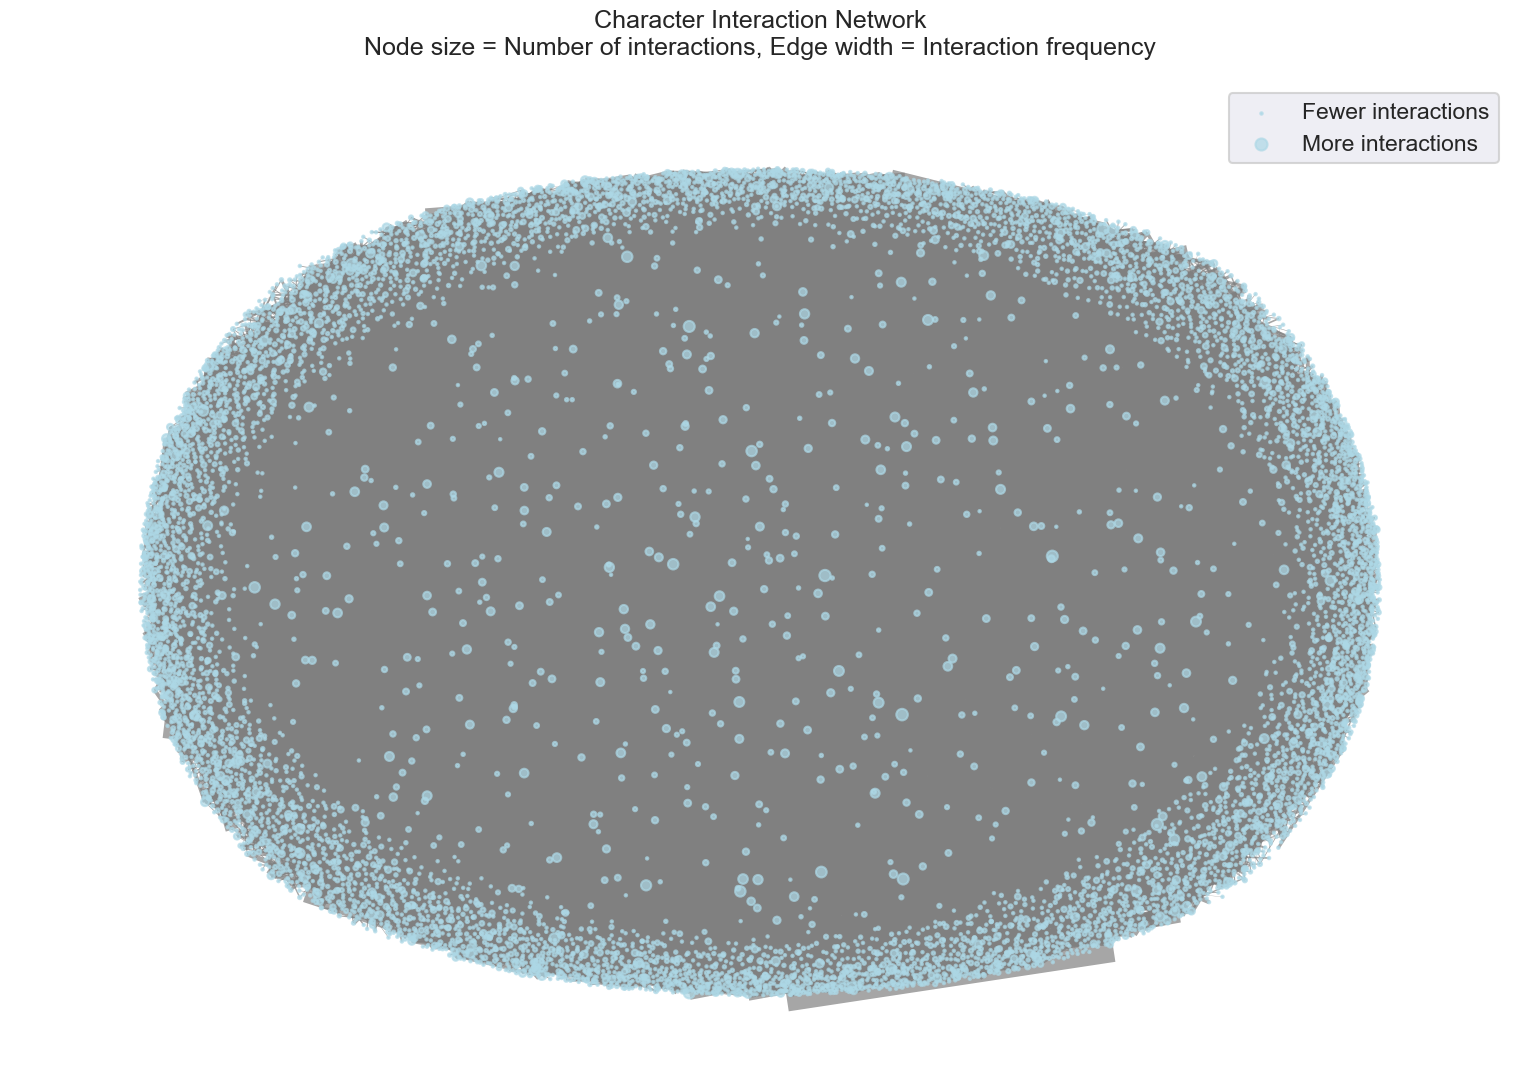

In [33]:
import matplotlib.pyplot as plt
import networkx as nx

# Create figure with a good size
plt.figure(figsize=(15, 10))

# Create a spring layout for better visualization
# Increase k to spread nodes further apart
pos = nx.spring_layout(G, k=1, iterations=50)

# Calculate node sizes based on degree centrality
node_sizes = [G.degree(node) * 3 for node in G.nodes()]

# Calculate edge widths based on weight
edge_widths = [G[u][v]['weight'] / 5 for (u, v) in G.edges()]

# Draw the network
nx.draw(G, pos,
        node_color='lightblue',     # Light color for nodes
        node_size=node_sizes,       # Size nodes by degree
        width=edge_widths,          # Width of edges based on weight
        edge_color='gray',          # Subtle edge color
        alpha=0.7,                  # Some transparency
        with_labels=False)          # No labels for cleaner look

# Add a title
plt.title("Character Interaction Network\nNode size = Number of interactions, Edge width = Interaction frequency", 
          pad=20)

# Add a simple legend
sizes = [min(node_sizes), max(node_sizes)]
labels = ['Fewer interactions', 'More interactions']
legend_elements = [plt.scatter([], [], s=size, c='lightblue', label=label, alpha=0.7)
                  for size, label in zip(sizes, labels)]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

#### DiGraph

In [9]:
# 1. First recreate the directed graph
import networkx as nx
from tqdm import tqdm
import ast

# Create a mapping from LineID to CharacterID
line_to_character = dict(zip(movie_lines['LineID'], movie_lines['CharacterID']))

# Create a directed graph
DG = nx.DiGraph()

# Build the directed graph from the movie conversations
for _, row in tqdm(movie_conversations.iterrows(), total=movie_conversations.shape[0]):
    try:
        # Get the conversation IDs directly
        conversation_ids = ast.literal_eval(row['Conversation'])
        
        # Add edges between consecutive lines
        for i in range(len(conversation_ids) - 1):
            line_id_1 = conversation_ids[i]
            line_id_2 = conversation_ids[i + 1]
            
            char1 = line_to_character.get(line_id_1)
            char2 = line_to_character.get(line_id_2)
            
            if char1 is not None and char2 is not None:
                # Add an edge from char1 to char2
                if DG.has_edge(char1, char2):
                    DG[char1][char2]['weight'] += 1
                else:
                    DG.add_edge(char1, char2, weight=1)
    except Exception as e:
        continue

# Print basic graph statistics to verify the graph was created successfully
print("\nGraph Statistics:")
print(f"Number of nodes: {DG.number_of_nodes()}")
print(f"Number of edges: {DG.number_of_edges()}")

100%|██████████| 83097/83097 [00:04<00:00, 18506.25it/s]


Graph Statistics:
Number of nodes: 9035
Number of edges: 20909


In [10]:
import networkx as nx
from tqdm import tqdm

# Create a mapping from LineID to CharacterID
line_to_character = dict(zip(movie_lines['LineID'], movie_lines['CharacterID']))

# Create a directed graph
DG = nx.DiGraph()

# Print a sample of the conversation data to understand its structure
print("Sample conversation data:")
print(movie_conversations['Conversation'].iloc[0])

# Build the directed graph from the movie conversations
for _, row in tqdm(movie_conversations.iterrows(), total=movie_conversations.shape[0]):
    try:
        # Get the conversation IDs directly
        conversation_ids = eval(row['Conversation'])  # Using eval since the data is a string representation of a list
        
        # Add edges between consecutive lines
        for i in range(len(conversation_ids) - 1):
            line_id_1 = conversation_ids[i]
            line_id_2 = conversation_ids[i + 1]
            
            char1 = line_to_character.get(line_id_1)
            char2 = line_to_character.get(line_id_2)
            
            if char1 is not None and char2 is not None:
                # Add an edge from char1 to char2
                if DG.has_edge(char1, char2):
                    DG[char1][char2]['weight'] += 1
                else:
                    DG.add_edge(char1, char2, weight=1)
    except Exception as e:
        continue

# Print basic graph statistics
print("\nGraph Statistics:")
print(f"Number of nodes: {DG.number_of_nodes()}")
print(f"Number of edges: {DG.number_of_edges()}")

# Print additional statistics
print("\nDetailed Graph Statistics:")
print(f"Number of nodes (unique characters): {DG.number_of_nodes()}")
print(f"Number of edges (character interactions): {DG.number_of_edges()}")
print(f"Average degree: {sum(dict(DG.degree()).values()) / DG.number_of_nodes():.2f}")
print(f"Number of strongly connected components: {nx.number_strongly_connected_components(DG)}")

# Print edge weight distribution
weights = [data['weight'] for _, _, data in DG.edges(data=True)]
print(f"\nEdge weight statistics:")
print(f"Min weight: {min(weights)}")
print(f"Max weight: {max(weights)}")
print(f"Average weight: {sum(weights)/len(weights):.2f}")


Sample conversation data:
['L194', 'L195', 'L196', 'L197']


100%|██████████| 83097/83097 [00:04<00:00, 18048.48it/s]


Graph Statistics:
Number of nodes: 9035
Number of edges: 20909

Detailed Graph Statistics:
Number of nodes (unique characters): 9035
Number of edges (character interactions): 20909
Average degree: 4.63
Number of strongly connected components: 984

Edge weight statistics:
Min weight: 1
Max weight: 291
Average weight: 10.60


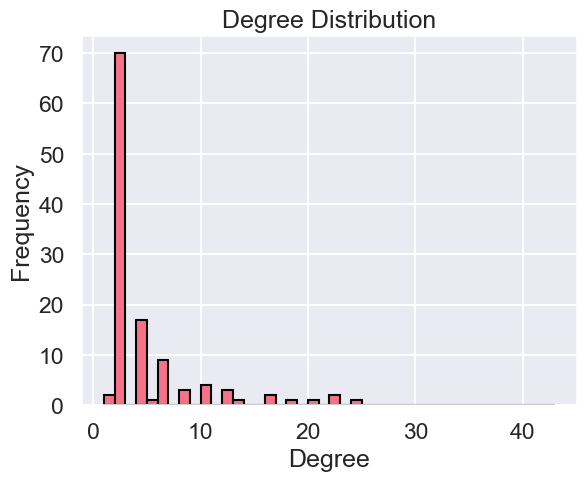

In [38]:
# plot the degree distribution
degrees = [val for (node, val) in DG.degree()]
plt.hist(degrees, bins=range(1, max(degrees)+20), edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


In [11]:
# Find the edge with maximum weight
max_weight_edge = max(DG.edges(data=True), key=lambda x: x[2]['weight'])
char1, char2, weight_data = max_weight_edge

# Get character names
char1_name = movie_lines[movie_lines['CharacterID'] == char1]['CharacterName'].iloc[0]
char2_name = movie_lines[movie_lines['CharacterID'] == char2]['CharacterName'].iloc[0]

print("\nMost Frequent Character Interaction:")
print(f"Between: {char1_name} and {char2_name}")
print(f"Number of interactions: {weight_data['weight']}")

# Find movie these characters appear in
movie_id = movie_lines[
    (movie_lines['CharacterID'] == char1) | 
    (movie_lines['CharacterID'] == char2)
]['MovieID'].iloc[0]

# Get and print movie title
movie_info = movie_titles[movie_titles['MovieID'] == movie_id].iloc[0]
print(f"\nMovie Details:")
print(f"Title: {movie_info['Title']}")
print(f"Year: {movie_info['Year']}")
print(f"Rating: {movie_info['Rating']}")
print(f"Votes: {movie_info['Votes']}")


Most Frequent Character Interaction:
Between: ALVY and ANNIE
Number of interactions: 291

Movie Details:
Title: annie hall
Year: 1977
Rating: 8.3
Votes: 66781


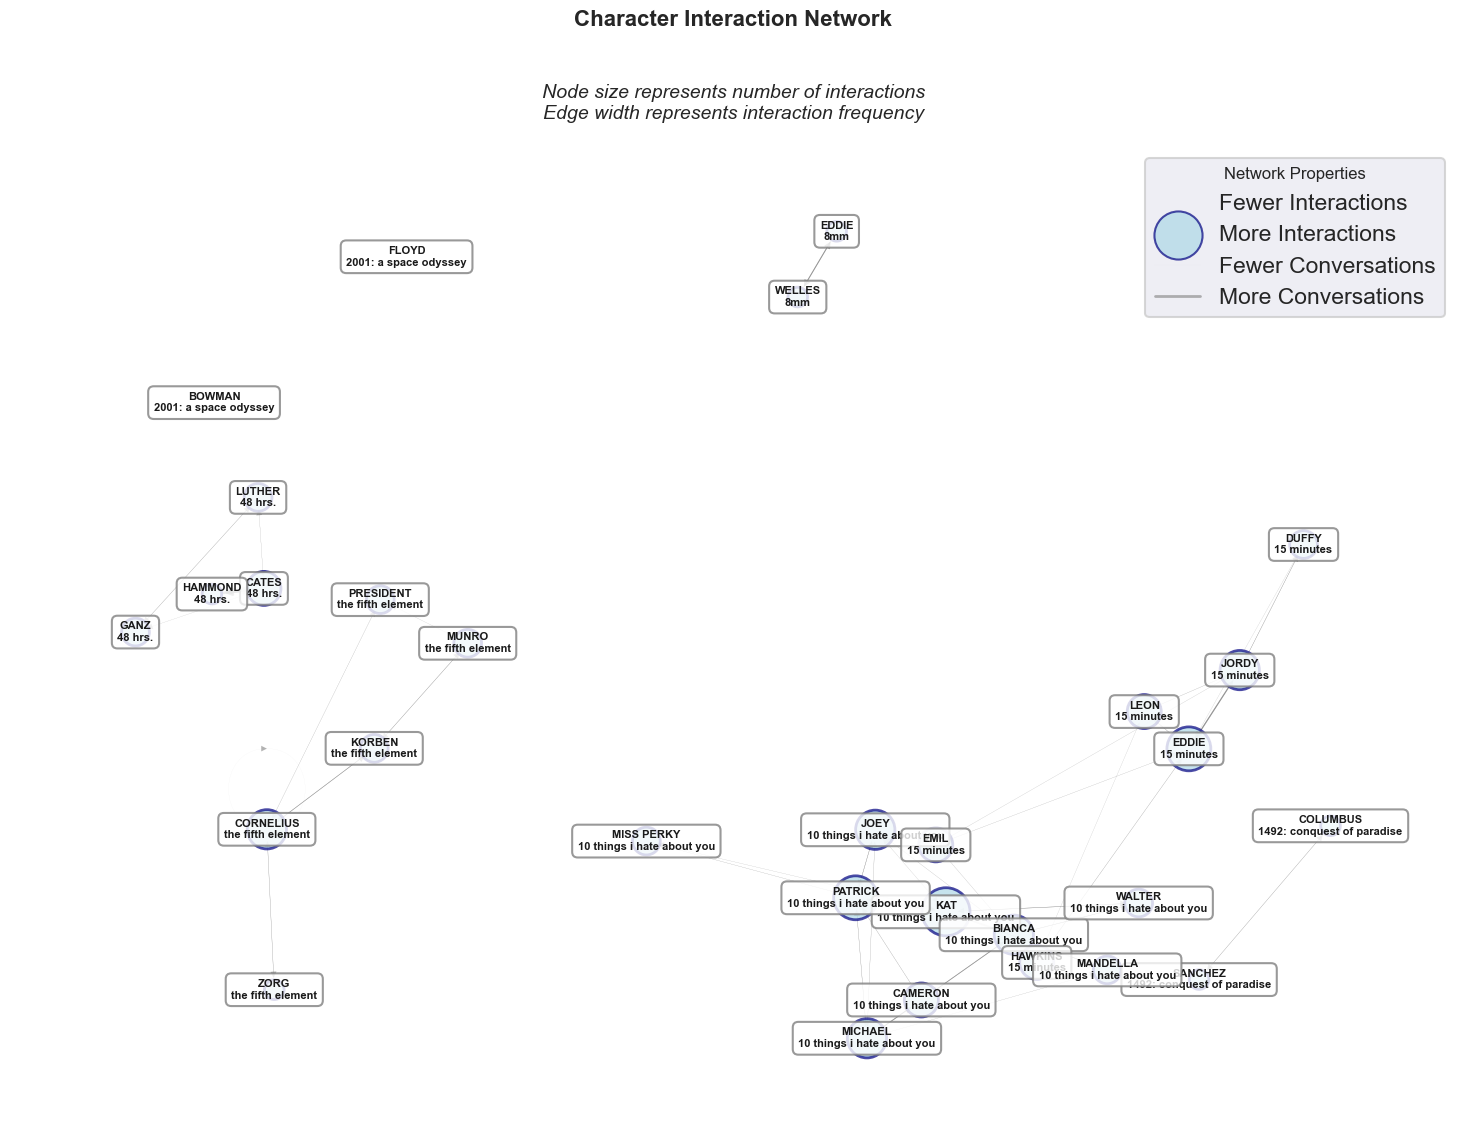

In [26]:
# Create necessary mappings
character_movie_dict = dict(zip(movie_lines['CharacterID'], movie_lines['MovieID']))
movie_dict = dict(zip(movie_titles['MovieID'], movie_titles['Title']))
character_names = dict(zip(movie_lines['CharacterID'], movie_lines['CharacterName']))

# Create a smaller subgraph of the most active characters
top_nodes = [n for n, d in sorted(DG.degree(), key=lambda x: x[1], reverse=True)[:30]]
subgraph = DG.subgraph(top_nodes)

# Create figure and axis with larger size
fig, ax = plt.subplots(figsize=(15, 12))
fig.suptitle("Character Interaction Network", fontsize=16, fontweight='bold', y=0.95)
ax.set_title("Node size represents number of interactions\nEdge width represents interaction frequency", 
             fontsize=14, style='italic', pad=20)

# Compute positions with more spacing
pos = nx.spring_layout(subgraph, k=2, iterations=100, seed=42)

# Extract node sizes based on degree
node_sizes = [subgraph.degree(n) * 100 for n in subgraph.nodes()]

# Draw nodes with enhanced appearance
nx.draw_networkx_nodes(
    subgraph, 
    pos, 
    ax=ax, 
    node_size=node_sizes, 
    node_color='lightblue',
    edgecolors='navy',
    linewidths=2,
    alpha=0.7
)

# Create enhanced labels with character names and movie titles
labels = {}
for node in subgraph.nodes():
    char_name = character_names.get(node, "Unknown")
    movie_id = character_movie_dict.get(node)
    movie_name = movie_dict.get(movie_id, "Unknown")
    
    # Split character name if it contains actor name
    if " / " in char_name:
        character, actor = char_name.split(" / ")
        label = f"{character}\n({actor})"
    else:
        label = char_name
        
    labels[node] = f"{label}\n{movie_name}"

# Draw labels with improved visibility
nx.draw_networkx_labels(
    subgraph, 
    pos, 
    ax=ax, 
    labels=labels,
    font_size=8,
    font_weight='bold',
    font_family="sans-serif",
    bbox=dict(facecolor='white', 
             edgecolor='gray',
             alpha=0.8,
             boxstyle='round,pad=0.5')
)

# Draw edges with varying width based on weight
edge_weights = [DG[u][v].get('weight', 1) for u, v in subgraph.edges()]
if edge_weights:  # Check if there are any edges
    max_weight = max(edge_weights)
    normalized_weights = [2 * w/max_weight for w in edge_weights]
    
    nx.draw_networkx_edges(
        subgraph,
        pos,
        ax=ax,
        width=normalized_weights,
        edge_color='red',
        alpha=0.6,
        arrows=True,
        arrowsize=10
    )

# Remove axis
ax.axis('off')

# Add legend for node sizes
sizes = [min(node_sizes), max(node_sizes)]
labels_size = ['Fewer Interactions', 'More Interactions']
legend_elements = [plt.scatter([], [], s=size, c='lightblue', 
                             edgecolor='navy', label=label, alpha=0.7)
                  for size, label in zip(sizes, labels_size)]

# Add legend for edge weights if there are edges
if edge_weights:
    weights = [min(edge_weights), max(edge_weights)]
    labels_weight = ['Fewer Conversations', 'More Conversations']
    for w, label in zip(weights, labels_weight):
        legend_elements.append(plt.Line2D([0], [0], color='gray', 
                                        linewidth=2*w/max_weight,
                                        label=label, alpha=0.6))

ax.legend(handles=legend_elements, loc='upper right', 
         title='Network Properties', title_fontsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Degree Distribution

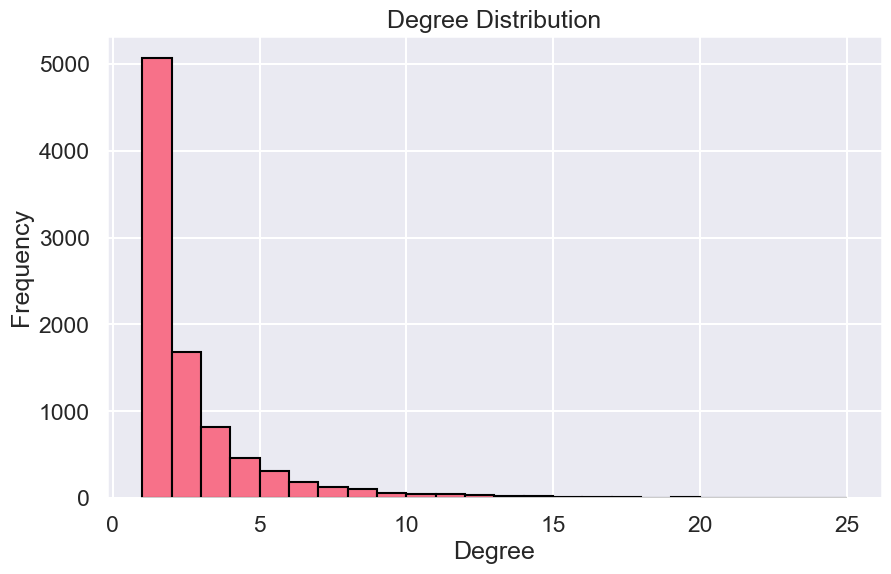

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(degrees, bins=range(1, max(degrees)+1), edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


In [14]:
import ast
import networkx as nx
from tqdm import tqdm

# Create a mapping from LineID to CharacterID
line_to_character = dict(zip(movie_lines['LineID'], movie_lines['CharacterID']))

# Create a directed graph
DG = nx.DiGraph()

# Build the directed graph from the movie conversations
for _, row in tqdm(movie_conversations.iterrows(), total=movie_conversations.shape[0]):
    try:
        conversation_ids = ast.literal_eval(row['Conversation'])
    except (ValueError, SyntaxError):
        continue  # Skip if the conversation cannot be parsed
    for i in range(len(conversation_ids) - 1):
        line_id_1 = conversation_ids[i]
        line_id_2 = conversation_ids[i + 1]
        char1 = line_to_character.get(line_id_1)
        char2 = line_to_character.get(line_id_2)
        if char1 is None or char2 is None:
            continue  # Skip if character IDs are missing
        # Add an edge from char1 to char2
        if DG.has_edge(char1, char2):
            DG[char1][char2]['weight'] += 1
        else:
            DG.add_edge(char1, char2, weight=1)


100%|██████████| 83097/83097 [00:04<00:00, 18187.52it/s]


#### Text Analysis

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import ast

nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Fill missing texts with empty strings
movie_lines['Text'] = movie_lines['Text'].fillna('')

# Map LineID to Text
line_dict = dict(zip(movie_lines['LineID'], movie_lines['Text']))

# Analyze sentiments in conversations
conversation_sentiments = []
for _, row in movie_conversations.iterrows():
    # Safely evaluate the string representation of the list
    conversation = ast.literal_eval(row['Conversation'])  # Use ast.literal_eval instead of eval
    # Fetch texts for each LineID, defaulting to empty string if not found
    conversation_texts = [line_dict.get(line_id, '') for line_id in conversation]
    # Ensure all items are strings (filter out None if any)
    conversation_texts = [text if text is not None else '' for text in conversation_texts]
    # Join the texts into a single string
    conversation_text = ' '.join(conversation_texts)
    # Analyze the sentiment
    sentiment = sia.polarity_scores(conversation_text)
    conversation_sentiments.append(sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jbhan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Integrating Networks and Text

In [16]:
# Assign sentiment scores to edges
for idx, (_, row) in enumerate(movie_conversations.iterrows()):
    char1, char2 = row['CharacterID1'], row['CharacterID2']
    sentiment = conversation_sentiments[idx]
    if G.has_edge(char1, char2):
        if 'sentiment' in G[char1][char2]:
            # Average the sentiments
            for key in sentiment:
                G[char1][char2]['sentiment'][key] = (G[char1][char2]['sentiment'][key] + sentiment[key]) / 2
        else:
            G[char1][char2]['sentiment'] = sentiment

# Sample edge attributes
for u, v, data in list(G.edges(data=True))[:5]:
    print(f"Edge ({u}, {v}) has attributes {data}")


Edge (u0, u2) has attributes {'weight': 25, 'sentiment': {'neg': 0.01247578513622284, 'neu': 0.7071444576382637, 'pos': 0.28037975722551345, 'compound': 0.2428581924498081}}
Edge (u0, u3) has attributes {'weight': 7, 'sentiment': {'neg': 0.006609375000000001, 'neu': 0.967734375, 'pos': 0.02565625, 'compound': 0.069071875}}
Edge (u0, u4) has attributes {'weight': 6, 'sentiment': {'neg': 0.027, 'neu': 0.85653125, 'pos': 0.11646875, 'compound': 0.228978125}}
Edge (u0, u5) has attributes {'weight': 18, 'sentiment': {'neg': 0.038111770629882816, 'neu': 0.9358338012695313, 'pos': 0.026058212280273437, 'compound': -0.05326019592285157}}
Edge (u0, u11) has attributes {'weight': 9, 'sentiment': {'neg': 0.113625, 'neu': 0.77920703125, 'pos': 0.10716796875000001, 'compound': -0.17263359375}}


#### Visualization of Sentiment on Edges

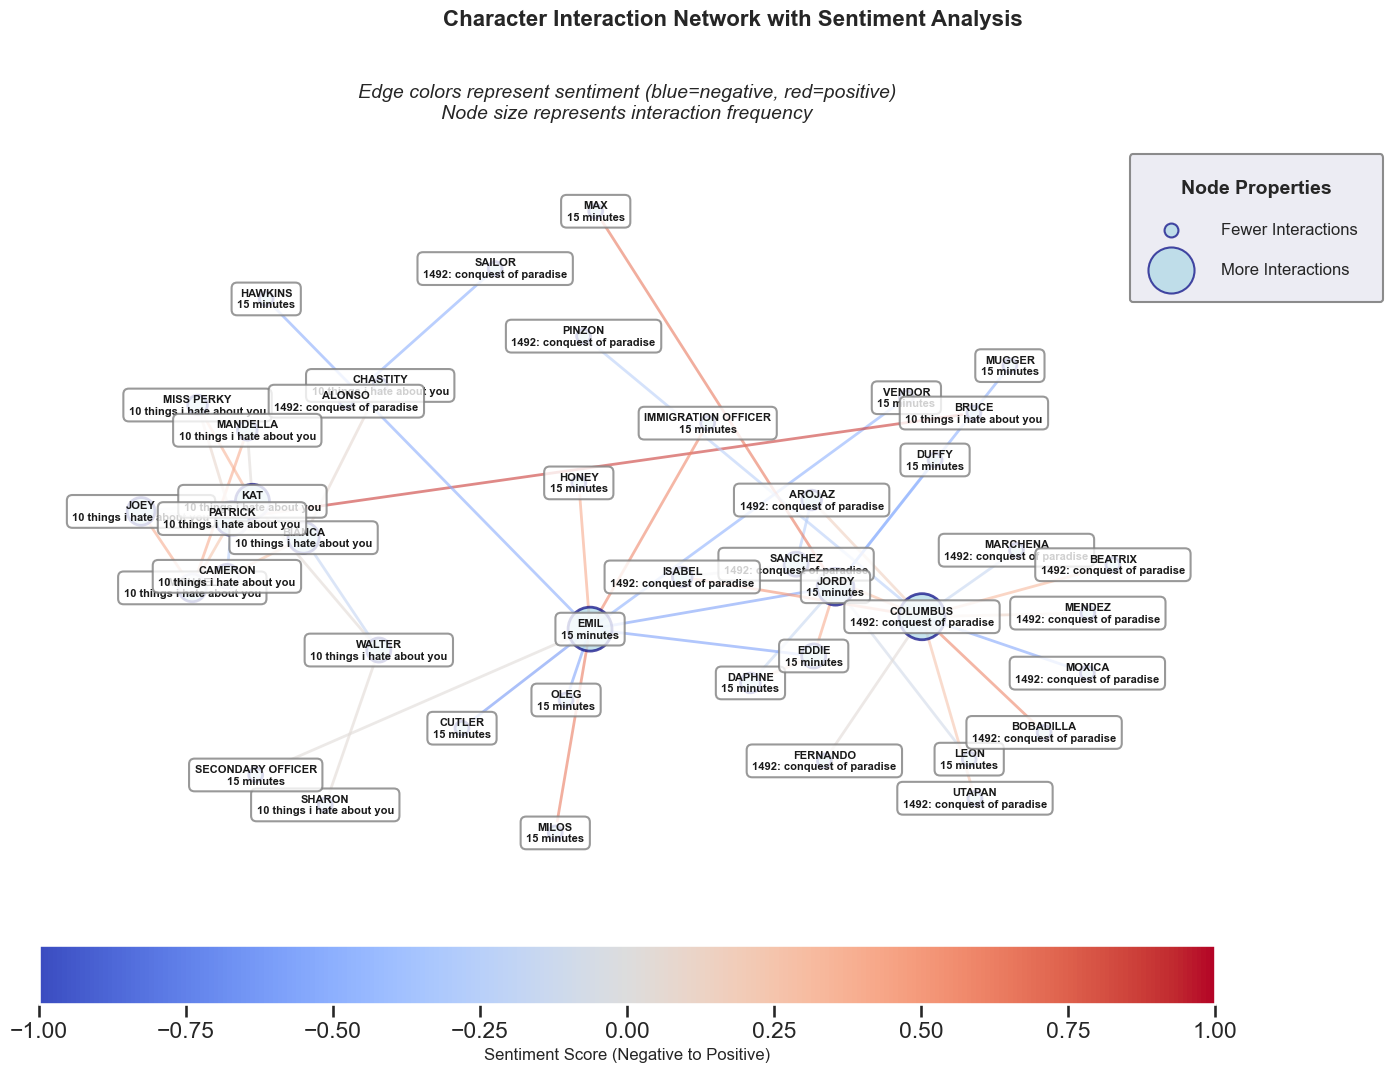

In [28]:
# Create necessary mappings and subgraph setup
character_movie_dict = dict(zip(movie_lines['CharacterID'], movie_lines['MovieID']))
movie_dict = dict(zip(movie_titles['MovieID'], movie_titles['Title']))
character_names = dict(zip(movie_lines['CharacterID'], movie_lines['CharacterName']))

# Create a subgraph of edges that have sentiment data
edges_with_sentiment = [(u, v) for u, v, data in G.edges(data=True) if 'sentiment' in data]
subgraph = G.edge_subgraph(edges_with_sentiment[:50])

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 12))
fig.suptitle("Character Interaction Network with Sentiment Analysis", fontsize=16, fontweight='bold', y=0.95)
ax.set_title("Edge colors represent sentiment (blue=negative, red=positive)\nNode size represents interaction frequency", 
             fontsize=14, style='italic', pad=20)

# Compute positions with more spacing
pos = nx.spring_layout(subgraph, k=2, iterations=100, seed=42)

# Extract node sizes based on degree
node_sizes = [subgraph.degree(n) * 100 for n in subgraph.nodes()]

# Draw nodes
nx.draw_networkx_nodes(
    subgraph, 
    pos, 
    ax=ax, 
    node_size=node_sizes, 
    node_color='lightblue',
    edgecolors='navy',
    linewidths=2,
    alpha=0.7
)

# Create enhanced labels with character names and movie titles
labels = {}
for node in subgraph.nodes():
    char_name = character_names.get(node, "Unknown")
    movie_id = character_movie_dict.get(node)
    movie_name = movie_dict.get(movie_id, "Unknown")
    
    # Split character name if it contains actor name
    if " / " in char_name:
        character, actor = char_name.split(" / ")
        label = f"{character}\n({actor})"
    else:
        label = char_name
    
    labels[node] = f"{label}\n{movie_name}"

# Draw labels with improved visibility
nx.draw_networkx_labels(
    subgraph, 
    pos, 
    ax=ax, 
    labels=labels,
    font_size=8,
    font_weight='bold',
    font_family="sans-serif",
    bbox=dict(facecolor='white', 
             edgecolor='gray',
             alpha=0.8,
             boxstyle='round,pad=0.5')
)

# Draw edges with sentiment colors
edge_colors = [data['sentiment']['compound'] for _, _, data in subgraph.edges(data=True)]
edges_collection = nx.draw_networkx_edges(
    subgraph,
    pos,
    ax=ax,
    edge_color=edge_colors,
    edge_cmap=plt.cm.coolwarm,
    edge_vmin=-1,
    edge_vmax=1,
    width=2,
    alpha=0.6,
    arrows=True,
    arrowsize=10
)

# Add colorbar
sm = mpl.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", pad=0.05)
cbar.set_label('Sentiment Score (Negative to Positive)', fontsize=12)

# Add legend with larger size and more padding
sizes = [min(node_sizes), max(node_sizes)]
labels_size = ['Fewer Interactions', 'More Interactions']
legend_elements = [plt.scatter([], [], s=size, c='lightblue', 
                             edgecolor='navy', label=label, alpha=0.7)
                  for size, label in zip(sizes, labels_size)]

# Create legend with increased font size and padding
legend = ax.legend(handles=legend_elements, 
                  loc='upper right',
                  title='Node Properties',
                  title_fontsize=14,  # Increased from 12
                  fontsize=12,        # Added explicit font size for labels
                  borderpad=1.5,      # Increased padding inside legend border
                  labelspacing=1.5,   # Increased spacing between legend entries
                  handletextpad=2,    # Increased spacing between handle and text
                  bbox_to_anchor=(1.15, 1.0),  # Moved legend slightly right
                  frameon=True,       # Ensure frame is visible
                  framealpha=0.9,     # Make background more opaque
                  edgecolor='gray')   # Add edge color to legend box

# Make the legend title bold
legend.get_title().set_fontweight('bold')

# Previous code for removing axis and adjusting layout remains the same...
ax.axis('off')
# Adjusted rect to accommodate larger legend
plt.tight_layout(rect=[0, 0.03, 0.95, 0.95])  # Left more space on the right
plt.show()